<a href="https://colab.research.google.com/github/Squiro/droidAmp/blob/master/HPC/Ejercicios/Sinopoli_Alesio_ejercicio_1_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Introducción**

El siguiente ejercicio remuestrea un archivo de audio haciendo uso del GPU. El objetivo del mismo es demostrar que las técnicas de remuestreo de señales de audio pueden ser ejecutadas en un entorno de ejecución en paralelo.

El muestreo digital es una de las partes del proceso de digitalización de señales, la cual consiste en tomar muestras de una señal analógica a una tasa constante (conocida como tasa de muestreo), con el fin de cuantificarlas posteriormente.

El remuestreo de señales [1] [2] [3] [4] de audio es un problema conocido y bastante común, que surge cuando se necesita convertir la tasa de muestreo (sampling rate) de un archivo de audio digital (es decir, audio analógico que ya fue digitalizado) en una tasa de muestreo diferente (sea esta mayor o menor). 

Incrementar la tasa de muestreo recibe el nombre de "Upsampling" o "Interoplación". Reducir la tasa de muestreo recibe el nombre de "Downsampling" o "decimación".

Un ejemplo común de remuestreo de audio presente en la vida real (aunque ya no tanto) sucedía cuando queríamos transferir el audio grabado en un CD a un medio diferente, por ejemplo, un DVD. La tasa de muestreo de un CD es de 44.1kHz (según el estándar ISO/IEC 60908), mientras que la de un DVD es de 96kHz, por lo que, al realizar la transferencia, se requiere un remuestreo del archivo de audio, para que el mismo cumpla con el formato de audio estándar de un DVD. 

En una CPU, los algoritmos de remuestro generalmente involucran una alta secuencialidad (es decir, involucran el uso de algun tipo de ciclo iterativo), pero esta secuencialidad no es obligatoria para el funcionamiento de los algoritmos, sino que más bien es una limitación impuesta por la programación de un solo hilo. 

En nuestro ejercicio, realizamos la adaptación en paralelismo de un algoritmo de remuestreo por interpolación lineal. Este algoritmo calcula nuevas muestras al realizar un promedio entre dos muestras del audio. El mismo es capaz de realizar Upsamplings (incrementos de la tasa de muestreo) en base a un entero ingresado por parámetro.

Si bien este algoritmo de remuestreo es uno de los más simples, sirve como base para demostrar que estas técnicas pueden ser aplicadas en paralelo, ahorrando así tiempo de procesamiento.

## **2. Armado del ambiente**

### **2.1 Instalación de los módulos necesarios**

**Pycuda:**

*PyCuda* es un wrapper que nos brinda la posibilidad utilizar la API de CUDA desde Python de una forma sencilla y rápida. Es necesario instalarlo a través de PIP para poder ejecutar este algoritmo.

**Soundfile:**

Soundfile es un package de Python especialmente diseñado para leer y escribir archivos de audio. Utilizaremos este módulo para leer el archivo de audio original, y escribir el archivo de audio remuestreado.

In [ ]:
!pip install pycuda
!pip install soundfile

     |████████████████████████████████| 1.6MB 8.1MB/s 
     |████████████████████████████████| 71kB 10.1MB/s 
     |████████████████████████████████| 81kB 10.2MB/s 
  Created wheel for pycuda: filename=pycuda-2020.1-cp36-cp36m-linux_x86_64.whl size=621010 sha256=767deee0bbe63cdd02b0645e4946a39a359c9ef28ef5908ac387184b36b154fd
  Stored in directory: /root/.cache/pip/wheels/8f/78/d1/5bb826f81d9d490297a348d818ff3ee6dd6f2075b06dde6ea0
  Created wheel for pytools: filename=pytools-2020.4.3-py2.py3-none-any.whl size=61374 sha256=419869a29e7a0d2025dfbcd499b40b7c2dcc9bb96762a68f80a05e49c74859af
  Stored in directory: /root/.cache/pip/wheels/af/c7/81/a22edb90b0b09a880468b2253bb1df8e9f503337ee15432c64
Successfully built pycuda pytools


### **2.2 Obtener el audio a remuestrear y setear el múltiplo de Upsampling**

En estos pasos descargaremos el archivo que será remuestrado y configuraremos el múltiplo de upsampling. Este múltiplo representa cuántas veces queremos multiplicar la tasa de muestreo del audio original. El múltiplo debe ser un número entero.

Utilizamos la herramienta *wget* presente en GNU/Linux para descargar el archivo de audio y almacenarlo en el entorno.

In [ ]:
url_audio = "https://drive.google.com/uc?id=10fInW_cC7PZK7_Iz3kju1qd45W4Tglt7" #@param {type:"string"}

!wget --no-check-certificate {url_audio} -O audio.wav

upsampling_scalar =  2#@param {type:"integer"}

--2020-11-14 22:29:16--  https://drive.google.com/uc?id=10fInW_cC7PZK7_Iz3kju1qd45W4Tglt7
Resolving drive.google.com (drive.google.com)... 74.125.142.138, 74.125.142.101, 74.125.142.102, ...
Connecting to drive.google.com (drive.google.com)|74.125.142.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-00-6s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/agb83co58okebg5gkob917r8sbf6oprh/1605392925000/13878950152691651096/*/10fInW_cC7PZK7_Iz3kju1qd45W4Tglt7 [following]
--2020-11-14 22:29:18--  https://doc-00-6s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/agb83co58okebg5gkob917r8sbf6oprh/1605392925000/13878950152691651096/*/10fInW_cC7PZK7_Iz3kju1qd45W4Tglt7
Resolving doc-00-6s-docs.googleusercontent.com (doc-00-6s-docs.googleusercontent.com)... 74.125.20.132, 2607:f8b0:400e:c07::84
Connecting to doc-00-6s-docs.googleusercontent.com (doc-00-6s-docs.googleusercontent.com)|74.125.

## **3. Desarrollo**
Ejecución del algoritmo de remuestreo.

In [ ]:
try: 
  import pycuda.driver as cuda
  import pycuda.autoinit
  from pycuda.compiler import SourceModule
  import soundfile as sf
  import numpy
  from datetime import datetime
except ImportError as e:
  print("Hubo un error al importar los módulos. Asegurese de haber ejecutado las celdas correspondientes a Armado del Ambiente.")
  print("Módulos faltantes: ")
  print(e)
  raise

# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0

audio_dir = "./audio.wav"

# Leemos el archivo de audio
try: 
  audio_cpu, sr = sf.read(file=audio_dir, dtype="float32")
  if (len(audio_cpu.shape) > 1):
    resample_cpu = numpy.resize(audio_cpu, (audio_cpu.shape[0]*upsampling_scalar, audio_cpu.shape[1]))
  else:
    resample_cpu = numpy.resize(audio_cpu, (audio_cpu.shape[0]*upsampling_scalar,))
except Exception as e:
  print("Hubo un error al abrir el archivo de audio: ")
  print(e)
  print("El programa se cerrará")
  raise

# CPU - reservo la memoria GPU.
audio_gpu = cuda.mem_alloc( audio_cpu.nbytes )
resample_gpu = cuda.mem_alloc( resample_cpu.nbytes )

# GPU - Copio la memoria al GPU.
cuda.memcpy_htod( audio_gpu, audio_cpu )

# CPU - Defino la función kernel que ejecutará en GPU.
module = SourceModule("""
__global__ void kernel_resample( int n, int upsampling_scalar, float *audio_original, float *audio_result)
{
  int idx = threadIdx.x + blockIdx.x*blockDim.x;

  if( idx < n )
  {
     audio_result[idx * 2] = audio_original[idx];
     //audio_result[idx * 2 + 1] = (audio_original[idx] + audio_original[idx + 1]) / 2;
     audio_result[idx * upsampling_scalar + 1] = (audio_original[idx] + audio_original[idx + 1]) / 2;
     for (int i = 2; i < upsampling_scalar; i++)
     {
        audio_result[idx * upsampling_scalar + i] = (audio_result[idx * upsampling_scalar + i] + audio_original[idx + 1]) / 2;
     }
       
  }
}
""") 
# CPU - Genero la función kernel.
kernel = module.get_function("kernel_resample")

# GPU - Ejecuta el kernel.
cantidad = len(resample_cpu)-1

dim_hilo = 256
dim_bloque = numpy.int( (cantidad+dim_hilo-1) / dim_hilo )
print( "Thread x: ", dim_hilo, ", Bloque x:", dim_bloque )

tiempo_gpu = datetime.now()

kernel( numpy.int32(cantidad), numpy.int32(upsampling_scalar), audio_gpu, resample_gpu, block=( dim_hilo, 1, 1 ),grid=(dim_bloque, 1,1) )

tiempo_gpu = datetime.now() - tiempo_gpu

print("Tiempo de ejecución: " + str(tiempo_en_ms(tiempo_gpu)) + " ms")

# GPU - Copio el resultado desde la memoria GPU.
cuda.memcpy_dtoh( resample_cpu, resample_gpu )

# Escribimos el archivo de audio remuestreado
sf.write('resample_audio_gpu.wav', resample_cpu, sr*2)

Thread x:  256 , Bloque x: 69543
Tiempo de ejecución: 0.173 ms


## **4. Tabla de pasos**

| Procesador | Función               | Detalle                                                                                                               |
|------------|-----------------------|-----------------------------------------------------------------------------------------------------------------------|
| CPU        | pip install           | Instalación de los módulos necesarios para la ejecución del script.                                                   |
| CPU        | wget url_achivo       | Descarga del archivo de audio que será remuestreado.                                                                  |
| CPU        | import                | Importa los módulos necesarios para el funcionamiento del script.                                                     |
| CPU        | librosa.load()        | Abre el audio como un array de numpy. Devuelve el sampling rate del archivo abierto.                                  |
| CPU        | numpy.ndarray.resize()    | Genera un array del doble del tamaño del original, conservando sus datos. |
| GPU        | cuda.mem_alloc()      | Reserva memoria para el audio en GPU.                                                                                 |
| GPU        | cuda.memcpy_htod()    | Copia el audio desde la memoria del procesador a la memoria de la GPU.                                                |
| CPU        | SourceModule          | String literal de Python que posee el código CUDA que será ejecutado en la GPU.                                       |
| CPU        | module.get_function() | Convierte el SourceModule del kernel en una función de Python.                                                        |
| CPU        | dim_hilo_x            | Cálculo de las dimensiones de los hilos para ejecución 1D.         
| CPU        | datetime.now() | Toma el tiempo actual.                                                       |                                                   |
| GPU        | kernel()              | Ejecución del código CUDA en la GPU, enviando los parámetros necesarios.                                              |
| CPU        | memcpy_dtoh           | Copia el área de memoria de la GPU donde se encuentra la imagen redimensionada a la memoria RAM.                      |
| CPU        | sf.write()            | Escribe el archivo de audio remuestreado.                                                                             |

## **5. Conclusiones**

### **Breve repaso**

Como nombramos en la introducción, el remuestreo es un problema común presente en muchas ocasiones de la vida real. El mismo consiste en incrementar o reducir la tasa de muestreo de un archivo de audio que ya fue digitalizado. 

En este ejercicio implementamos el algoritmo de remuestreo por interpolación lineal, con el objetivo de multiplicar la tasa de muestreo del audio original. Este algoritmo calcula nuevas muestras al realizar un promedio entre dos muestras del audio.

### **Resultados**

Para comparar resultados, decidimos ejecutar el ejercicio con el archivo de audio nombrado en el punto 2.2 y un upsampling_scalar igual a 2.

Al finalizar de ejecutar el ejercicio, obtendremos como resultado un audio que posee el doble de la tasa de muestreo que el audio original. El lector de este notebook puede comprobar esto por sus propios medios descargando el archivo resample_audio_gpu.wav y utilizando algún programa de edición de audio como Audacity.

De todas formas, ilustramos los resultados con las siguientes imágenes, tomadas desde Audacity:

1. En esta figura podemos observar cómo Audacity interpreta la tasa de muestreo de cada archivo. La primera fila representa al archivo original. La segunda representa al archivo remuestreado. Se observa que, en el caso de la primera fila, la tasa de muestreo tiene un valor de 44100Hz, mientras que la segunda posee un valor de 882000Hz (el doble que la primera).

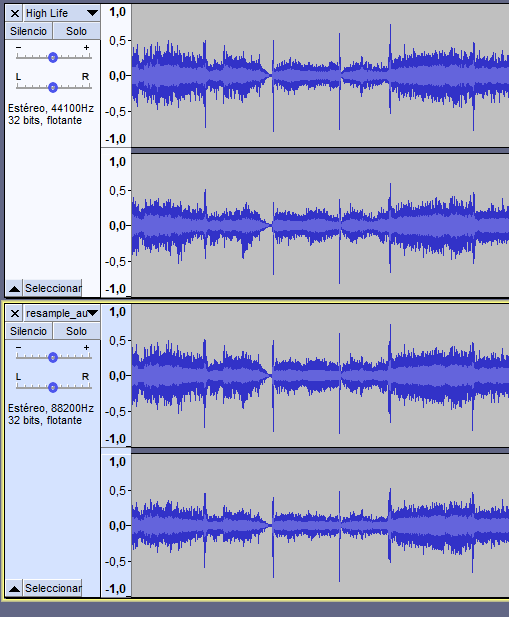

2. En la siguiente figura realizamos un zoom a una de las secciones del audio. Si el remuestreo se hizo correctamente, esta imagen debería mostrar que el audio remuestreado posee el doble de cantidad de muestras en la misma sección que el audio original. 

Podemos observar que el audio original posee 18 muestras en la sección, mientras que el audio remuestreado posee 36. El remuestreo se realizó correctamente y se duplicó la tasa de muestras del audio.

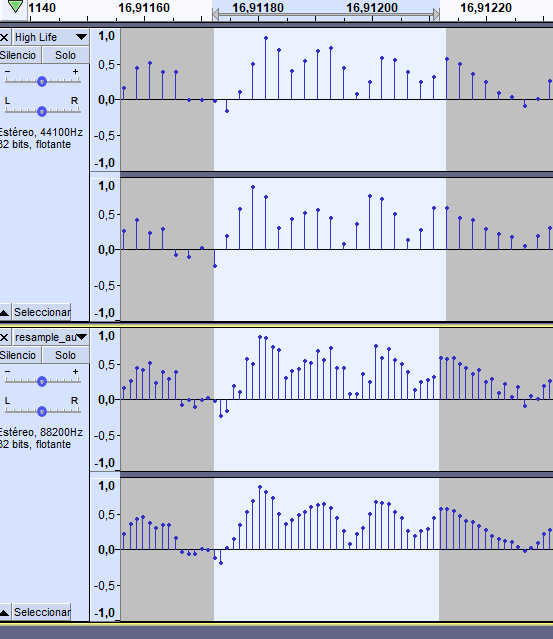

### **Comparaciones**

Ambas implementaciones del algoritmo (secuencial mediante CPU y paralelo mediante GPU) nos darán el mismo resultado. La gran ventaja de aplicar la secuencialidad la podemos observar al comparar los tiempos de ejecución de cada algoritmo.

Utilizando el archivo de audio mencionado en el punto 2.2 de este notebook obtuvimos los siguientes tiempos de ejecución en cada versión de este algoritmo:

| Tipo procesador | Tiempo de ejecución (ms) |
|-----------------|----------------------------------|
| GPU             | 1.601 ms                         |
| CPU             | 37060.104 ms                     |

Si bien los resultados hablan por sí solos, podemos concluir lo siguiente: en el tiempo que le lleva a un CPU realizar este trabajo, una GPU puede realizar el mismo trabajo 23148 veces. Esto implica una mejora abismal en los tiempos de ejecución.

### **Sugerencias**

Como establecimos anteriormente, el algoritmo de interpolación lineal es uno de los algoritmos más simples para el remuestreo de audio. Si bien cumple con su trabajo, es un algoritmo que tiene un desempeño pobre y puede producir una mala calidad de audio. Existen otras variedades de algoritmos que mantienen la calidad del audio, pero que resultan más complejas de implementar o necesitan una mayor complejidad computacional debido a la realización de más cálculos. 

Este ejercicio podría continuarse explorando la amplia diversidad de algoritmos de remuestreo. Incluso se podría hacer un análisis que evalúe cada algoritmo y compare: 1. cuál es el que mejor resultados arroja y 2. cuál se beneficia más de la ejecución en paralelo.

### **Lecciones aprendidas**

La rapidez obtenida debido al uso del paralelismo es un beneficio para nada menospreciable, especialmente cuando tenemos la necesidad de recorrer secuencialmente todas las posiciones de un vector. Más aún si tenemos en cuenta que las GPUs poseen una ventaja por sobre los CPUs en la realización de cálculos matemáticos.

Si bien este ejercicio puede ser considerado insignificante en lo que respecta a algoritmos de paralelismo, nos sirve para darnos cuenta de por qué las GPU revolucionaron todo lo relacionado a la disciplina de Ciencia de Datos en estos últimos años. Si en un ejercicio simple como este podemos observar las mejoras que se obtienen en base al paralelismo, no resulta sorprendiente que la Ciencia de Datos utilice las mismas técnicas para su beneficio.

## **6. Bibliografía**

[1] Andreas Wilde, An Analysis of Sample Rate Conversion in Sox, 19. Dec. 2003 [En línea] Disponible en: http://www.leute.server.de/wilde/resample.html 

[2] Lyons, Richard (2010). "10. Sample Rate Conversion". Understanding Digital Signal Processing. Prentice Hall. ISBN 978-0137027415. 

[3]  Oppenheim, Alan V., Schafer, Ronald W. y Buck, John R. (1999). "4.6.2". Discrete-Time Signal Processing (2nd ed.). Upper Saddle River, N.J.: Prentice Hall. p. 172. ISBN 0-13-754920-2. Also available at https://d1.amobbs.com/bbs_upload782111/files_24/ourdev_523225.pdf

[4] PeakPro 5 Sample Rate Converter Comparison with Other Audio Applications, Bias Inc., December 2005. [En línea] Disponible en: http://www.audiodesignguide.com/DAC_final/peakResamplingWhitePaper.pdf